In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn import preprocessing

from sklearn.metrics import roc_auc_score


from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)


# Dataset

In [22]:
dataset = "/home/flo/Documents/projet/k8s-security-module/05__data netflow/dataset/NetFlow v1 Datasets/NetFlow v1 Datasets/NF-UNSW-NB15.csv"
df = pd.read_csv(dataset)
print('Dimensions of the Test set:',df.shape)

Dimensions of the Test set: (1623118, 14)


In [23]:
df.dtypes

IPV4_SRC_ADDR                  object
L4_SRC_PORT                     int64
IPV4_DST_ADDR                  object
L4_DST_PORT                     int64
PROTOCOL                        int64
L7_PROTO                      float64
IN_BYTES                        int64
OUT_BYTES                       int64
IN_PKTS                         int64
OUT_PKTS                        int64
TCP_FLAGS                       int64
FLOW_DURATION_MILLISECONDS      int64
Label                           int64
Attack                         object
dtype: object

In [24]:
# All cols in the dataset
cols = ['IPV4_SRC_ADDR','L4_SRC_PORT','IPV4_DST_ADDR','L4_DST_PORT','PROTOCOL','L7_PROTO','IN_BYTES', 'OUT_BYTES','IN_PKTS','OUT_PKTS','TCP_FLAGS','FLOW_DURATION_MILLISECONDS','Label','Attack']

# Selected cols 
selected_cols = ['L4_SRC_PORT','L4_DST_PORT','PROTOCOL','L7_PROTO','IN_BYTES', 'OUT_BYTES','IN_PKTS','OUT_PKTS','FLOW_DURATION_MILLISECONDS']

In [25]:
data = df[selected_cols].copy() 
data = data[:50000]
show_df = df[:50000]

In [26]:
#Split IP adress
data[['IPV4_SRC_ADDR1', 'IPV4_SRC_ADDR2','IPV4_SRC_ADDR3', 'IPV4_SRC_ADDR4']] = df.IPV4_SRC_ADDR.str.split(".", expand = True)
data[['IPV4_DST_ADDR1', 'IPV4_DST_ADDR2','IPV4_DST_ADDR3', 'IPV4_DST_ADDR4']] = df.IPV4_DST_ADDR.str.split(".", expand = True)


In [27]:
# hash ip adress
hashencod = ['L4_SRC_PORT','L4_DST_PORT']
for h in hashencod:
    data[h] = pd.util.hash_pandas_object(data[h])%100

In [28]:
# Label encod
cols_labelencod = ['PROTOCOL','L7_PROTO','IN_PKTS','OUT_PKTS']

for x in cols_labelencod:
    labelencoder= LabelEncoder()
    data[x] = labelencoder.fit_transform(data[x])



In [29]:
# split cols
data_encod = pd.get_dummies(data, columns=['L4_SRC_PORT','L4_DST_PORT','PROTOCOL','L7_PROTO','IN_PKTS','OUT_PKTS'])

In [30]:
data_encod.dtypes

IN_BYTES                       int64
OUT_BYTES                      int64
FLOW_DURATION_MILLISECONDS     int64
IPV4_SRC_ADDR1                object
IPV4_SRC_ADDR2                object
                               ...  
OUT_PKTS_144                   uint8
OUT_PKTS_145                   uint8
OUT_PKTS_146                   uint8
OUT_PKTS_147                   uint8
OUT_PKTS_148                   uint8
Length: 944, dtype: object

# IsolationForest

In [31]:
iForest = IsolationForest(n_estimators=1750, max_samples=13, contamination=0.086, n_jobs=-1)
iForest.fit(data_encod)



/usr/local/lib/python3.9/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.086, max_samples=13, n_estimators=1750,
                n_jobs=-1)

# Finding anomalies dataset

In [32]:
scores = iForest.decision_function(data_encod)

(array([6.000e+00, 2.000e+00, 0.000e+00, 6.000e+00, 2.000e+00, 1.700e+01,
        1.380e+02, 3.090e+02, 1.000e+02, 4.000e+01, 1.120e+02, 1.161e+03,
        6.130e+02, 1.170e+02, 1.620e+02, 1.990e+02, 3.500e+02, 4.030e+02,
        3.540e+02, 3.510e+02, 3.310e+02, 2.680e+02, 2.250e+02, 2.230e+02,
        7.310e+02, 2.279e+03, 4.291e+03, 4.122e+03, 2.699e+03, 1.368e+03,
        1.613e+03, 1.407e+03, 1.176e+03, 1.524e+03, 2.184e+03, 2.441e+03,
        2.213e+03, 1.984e+03, 2.564e+03, 3.030e+03, 2.866e+03, 2.198e+03,
        1.651e+03, 1.110e+03, 6.370e+02, 2.800e+02, 9.700e+01, 3.500e+01,
        9.000e+00, 2.000e+00]),
 array([-0.03620907, -0.03436145, -0.03251382, -0.0306662 , -0.02881858,
        -0.02697096, -0.02512334, -0.02327571, -0.02142809, -0.01958047,
        -0.01773285, -0.01588523, -0.0140376 , -0.01218998, -0.01034236,
        -0.00849474, -0.00664712, -0.00479949, -0.00295187, -0.00110425,
         0.00074337,  0.00259099,  0.00443862,  0.00628624,  0.00813386,
         0.

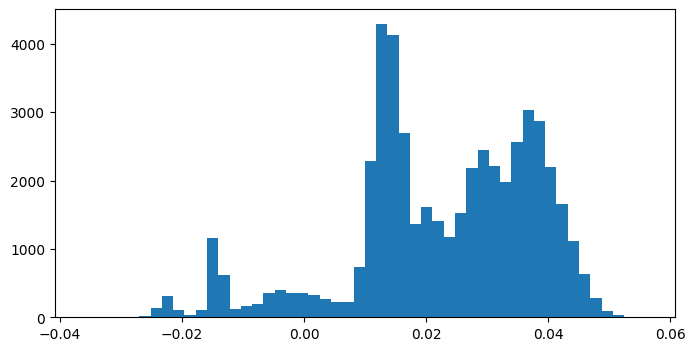

In [33]:
plt.figure(figsize=(8, 4))
plt.hist(scores, bins=50)

In [34]:
show_df['scores']=scores
show_df['anomaly']=iForest.predict(data_encod)
show_df.head(5)

/tmp/ipykernel_848248/1321330837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  show_df['scores']=scores
/tmp/ipykernel_848248/1321330837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  show_df['anomaly']=iForest.predict(data_encod)


,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,scores,anomaly
0,149.171.126.0,62073,59.166.0.5,56082,6,0.0,9672,416,11,8,25,15,0,Benign,0.020738,1
1,149.171.126.2,32284,59.166.0.5,1526,6,0.0,1776,104,6,2,25,0,0,Benign,0.020007,1
2,149.171.126.0,21,59.166.0.1,21971,6,1.0,1842,1236,26,22,25,1111,0,Benign,0.028976,1
3,59.166.0.1,23800,149.171.126.0,46893,6,0.0,528,8824,10,12,27,124,0,Benign,0.029484,1
4,59.166.0.5,63062,149.171.126.2,21,6,1.0,1786,2340,32,34,25,1459,0,Benign,0.046250,1


In [35]:
# Total BENIGN in dataset
df_benign = show_df[show_df['Label']==0]
df_benign.shape

(45749, 16)

In [36]:
# Total ATTACK in dataset
df_attack = show_df[show_df['Label']==1]
df_attack.shape

(4251, 16)

In [37]:
#dataset anomaly
df_anomly = show_df[show_df['anomaly']==-1]
df_anomly.shape

(4300, 16)

In [38]:
# BENIGN in anomaly
df_anomaly_benign =  df_anomly[df_anomly['Label']==0]
df_anomaly_benign.shape

(649, 16)

In [39]:
# ATTACK in anomaly
df_anomly_attack =  df_anomly[df_anomly['Label']==1]
df_anomly_attack.shape

(3651, 16)

In [40]:
# undetected attacks
df_healthy = show_df[show_df['anomaly']==1]
df_true_negative = df_healthy[df_healthy['Label']==1]
df_true_negative.shape

(600, 16)